## Full optimizer comparison
Notebook written by Lanyue Zhang and Alan Kaptanoglu

This post-processing file takes the results from Pareto-optimal scans of the dysts database with different optimizers and varying amounts of noise, as in the example Jupyter notebook 16_benchmark_paper.ipynb. The primary goal of this notebook is to fully reproduce the results shown in our new system identification benchmark paper.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
from dysts.equation_utils import *
import time
import pysindy as ps

path = 'data/'

In [2]:
# Import list of the dynamical properties, sorted alphabetically by the system names

medl_list = np.loadtxt('description_lengths')
lyap_list = np.loadtxt('lyapunov_exponents')
nonlinear_sum = np.loadtxt('nonlinearity_metric')
scale_list_avg = np.loadtxt('scale_separation_metric')
systems_list_cleaned = np.loadtxt('systems_list_cleaned', dtype=str)
num_attractors = len(medl_list)

### Import normalized X_dot RMSE errors and normalized model coefficient errors
This is done for the STLSQ, SR3 (nu = 1 and nu = 0.1), Lasso, and MIOSR optimizers AND the STLSQ optimizer using the weak form!

In [3]:
avg_rmse_error_STLSQ_AIC = np.loadtxt(path + 'avg_rmse_error_STLSQ_AIC')
std_rmse_error_STLSQ_AIC = np.loadtxt(path + 'std_rmse_error_STLSQ_AIC')
avg_coef_error_STLSQ_AIC = np.loadtxt(path + 'avg_coef_error_STLSQ_AIC')
std_coef_error_STLSQ_AIC = np.loadtxt(path + 'std_coef_error_STLSQ_AIC')

avg_rmse_error_SR3_AIC = np.loadtxt(path + 'avg_rmse_error_SR3_AIC')
std_rmse_error_SR3_AIC = np.loadtxt(path + 'std_rmse_error_SR3_AIC')
avg_coef_error_SR3_AIC = np.loadtxt(path + 'avg_coef_error_SR3_AIC')
std_coef_error_SR3_AIC = np.loadtxt(path + 'std_coef_error_SR3_AIC')

avg_rmse_error_SR3_nu01_AIC = np.loadtxt(path + 'avg_rmse_error_SR3_nu1e-1_AIC')
std_rmse_error_SR3_nu01_AIC = np.loadtxt(path + 'std_rmse_error_SR3_nu1e-1_AIC')
avg_coef_error_SR3_nu01_AIC = np.loadtxt(path + 'avg_coef_error_SR3_nu1e-1_AIC')
std_coef_error_SR3_nu01_AIC = np.loadtxt(path + 'std_coef_error_SR3_nu1e-1_AIC')

avg_rmse_error_Lasso_AIC = np.loadtxt(path + 'avg_rmse_error_Lasso_AIC')
std_rmse_error_Lasso_AIC = np.loadtxt(path + 'std_rmse_error_Lasso_AIC')
avg_coef_error_Lasso_AIC = np.loadtxt(path + 'avg_coef_error_Lasso_AIC')
std_coef_error_Lasso_AIC = np.loadtxt(path + 'std_coef_error_Lasso_AIC')

avg_rmse_error_MIOSR_AIC = np.loadtxt(path + 'avg_rmse_error_MIOSR_AIC')
std_rmse_error_MIOSR_AIC = np.loadtxt(path + 'std_rmse_error_MIOSR_AIC')
avg_coef_error_MIOSR_AIC = np.loadtxt(path + 'avg_coef_error_MIOSR_AIC')
std_coef_error_MIOSR_AIC = np.loadtxt(path + 'std_coef_error_MIOSR_AIC')

avg_rmse_error_STLSQ_AIC_01 = np.loadtxt(path + 'avg_rmse_error_STLSQ_AIC_noise01')
std_rmse_error_STLSQ_AIC_01 = np.loadtxt(path + 'std_rmse_error_STLSQ_AIC_noise01')
avg_coef_error_STLSQ_AIC_01 = np.loadtxt(path + 'avg_coef_error_STLSQ_AIC_noise01')
std_coef_error_STLSQ_AIC_01 = np.loadtxt(path + 'std_coef_error_STLSQ_AIC_noise01')

avg_rmse_error_SR3_AIC_01 = np.loadtxt(path + 'avg_rmse_error_SR3_AIC_noise01')
std_rmse_error_SR3_AIC_01 = np.loadtxt(path + 'std_rmse_error_SR3_AIC_noise01')
avg_coef_error_SR3_AIC_01 = np.loadtxt(path + 'avg_coef_error_SR3_AIC_noise01')
std_coef_error_SR3_AIC_01 = np.loadtxt(path + 'std_coef_error_SR3_AIC_noise01')

avg_rmse_error_SR3_nu01_AIC_01 = np.loadtxt(path + 'avg_rmse_error_SR3_nu1e-1_AIC_noise01')
std_rmse_error_SR3_nu01_AIC_01 = np.loadtxt(path + 'std_rmse_error_SR3_nu1e-1_AIC_noise01')
avg_coef_error_SR3_nu01_AIC_01 = np.loadtxt(path + 'avg_coef_error_SR3_nu1e-1_AIC_noise01')
std_coef_error_SR3_nu01_AIC_01 = np.loadtxt(path + 'std_coef_error_SR3_nu1e-1_AIC_noise01')

avg_rmse_error_Lasso_AIC_01 = np.loadtxt(path + 'avg_rmse_error_Lasso_AIC_noise01')
std_rmse_error_Lasso_AIC_01 = np.loadtxt(path + 'std_rmse_error_Lasso_AIC_noise01')
avg_coef_error_Lasso_AIC_01 = np.loadtxt(path + 'avg_coef_error_Lasso_AIC_noise01')
std_coef_error_Lasso_AIC_01 = np.loadtxt(path + 'std_coef_error_Lasso_AIC_noise01')

avg_rmse_error_MIOSR_AIC_01 = np.loadtxt(path + 'avg_rmse_error_MIOSR_AIC_noise01')
std_rmse_error_MIOSR_AIC_01 = np.loadtxt(path + 'std_rmse_error_MIOSR_AIC_noise01')
avg_coef_error_MIOSR_AIC_01 = np.loadtxt(path + 'avg_coef_error_MIOSR_AIC_noise01')
std_coef_error_MIOSR_AIC_01 = np.loadtxt(path + 'std_coef_error_MIOSR_AIC_noise01')

avg_rmse_error_STLSQ_AIC_1 = np.loadtxt(path + 'avg_rmse_error_STLSQ_AIC_noise1')
std_rmse_error_STLSQ_AIC_1 = np.loadtxt(path + 'std_rmse_error_STLSQ_AIC_noise1')
avg_coef_error_STLSQ_AIC_1 = np.loadtxt(path + 'avg_coef_error_STLSQ_AIC_noise1')
std_coef_error_STLSQ_AIC_1 = np.loadtxt(path + 'std_coef_error_STLSQ_AIC_noise1')

avg_rmse_error_SR3_AIC_1 = np.loadtxt(path + 'avg_rmse_error_SR3_AIC_noise1')
std_rmse_error_SR3_AIC_1 = np.loadtxt(path + 'std_rmse_error_SR3_AIC_noise1')
avg_coef_error_SR3_AIC_1 = np.loadtxt(path + 'avg_coef_error_SR3_AIC_noise1')
std_coef_error_SR3_AIC_1 = np.loadtxt(path + 'std_coef_error_SR3_AIC_noise1')

avg_rmse_error_SR3_nu01_AIC_1 = np.loadtxt(path + 'avg_rmse_error_SR3_nu1e-1_AIC_noise1')
std_rmse_error_SR3_nu01_AIC_1 = np.loadtxt(path + 'std_rmse_error_SR3_nu1e-1_AIC_noise1')
avg_coef_error_SR3_nu01_AIC_1 = np.loadtxt(path + 'avg_coef_error_SR3_nu1e-1_AIC_noise1')
std_coef_error_SR3_nu01_AIC_1 = np.loadtxt(path + 'std_coef_error_SR3_nu1e-1_AIC_noise1')

avg_rmse_error_Lasso_AIC_1 = np.loadtxt(path + 'avg_rmse_error_Lasso_AIC_noise1')
std_rmse_error_Lasso_AIC_1 = np.loadtxt(path + 'std_rmse_error_Lasso_AIC_noise1')
avg_coef_error_Lasso_AIC_1 = np.loadtxt(path + 'avg_coef_error_Lasso_AIC_noise1')
std_coef_error_Lasso_AIC_1 = np.loadtxt(path + 'std_coef_error_Lasso_AIC_noise1')

avg_rmse_error_MIOSR_AIC_1 = np.loadtxt(path + 'avg_rmse_error_MIOSR_AIC_noise1')
std_rmse_error_MIOSR_AIC_1 = np.loadtxt(path + 'std_rmse_error_MIOSR_AIC_noise1')
avg_coef_error_MIOSR_AIC_1 = np.loadtxt(path + 'avg_coef_error_MIOSR_AIC_noise1')
std_coef_error_MIOSR_AIC_1 = np.loadtxt(path + 'std_coef_error_MIOSR_AIC_noise1')

# import weak form results with STLSQ
avg_rmse_error_STLSQ_AICwf = np.loadtxt(path + 'avg_rmse_error_strong_STLSQ_AIC_weakform_noise0')
std_rmse_error_STLSQ_AICwf = np.loadtxt(path + 'std_rmse_error_STLSQ_AIC_weakform_noise0')
avg_coef_error_STLSQ_AICwf = np.loadtxt(path + 'avg_coef_error_STLSQ_AIC_weakform_noise0')
std_coef_error_STLSQ_AICwf = np.loadtxt(path + 'std_coef_error_STLSQ_AIC_weakform_noise0')

avg_rmse_error_STLSQ_AICwf_01 = np.loadtxt(path + 'avg_rmse_error_strong_STLSQ_AIC_weakform_noise01')
std_rmse_error_STLSQ_AICwf_01 = np.loadtxt(path + 'std_rmse_error_STLSQ_AIC_weakform_noise01')
avg_coef_error_STLSQ_AICwf_01 = np.loadtxt(path + 'avg_coef_error_STLSQ_AIC_weakform_noise01')
std_coef_error_STLSQ_AICwf_01 = np.loadtxt(path + 'std_coef_error_STLSQ_AIC_weakform_noise01')

avg_rmse_error_STLSQ_AICwf_1 = np.loadtxt(path + 'avg_rmse_error_strong_STLSQ_AIC_weakform_noise1')
std_rmse_error_STLSQ_AICwf_1 = np.loadtxt(path + 'std_rmse_error_STLSQ_AIC_weakform_noise1')
avg_coef_error_STLSQ_AICwf_1 = np.loadtxt(path + 'avg_coef_error_STLSQ_AIC_weakform_noise1')
std_coef_error_STLSQ_AICwf_1 = np.loadtxt(path + 'std_coef_error_STLSQ_AIC_weakform_noise1')

### Plot all the errors for all the optimizers and all the systems, on a single figure!
First plot will be all the results when the data is clean -- no added noise.

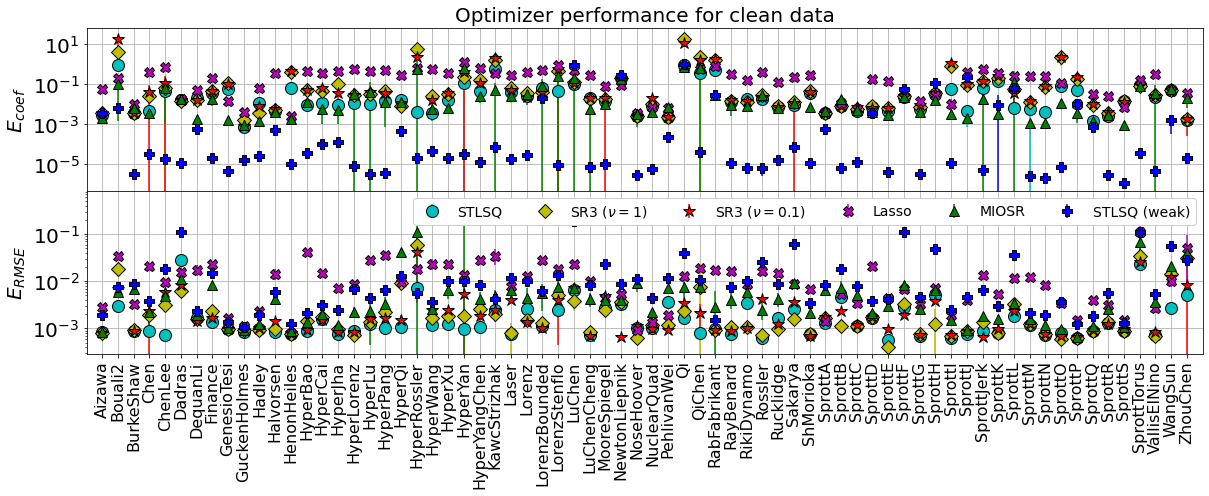

In [4]:
import matplotlib.gridspec as gridspec

ms = 10
plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(2, 1, hspace=0, wspace=0)
plt.subplot(gs[0])
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_STLSQ_AIC,
    std_coef_error_STLSQ_AIC,
    fmt="co",
    label="STLSQ",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_SR3_AIC,
    std_coef_error_SR3_AIC,
    fmt="yD",
    label="SR3",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_SR3_nu01_AIC,
    std_coef_error_SR3_nu01_AIC,
    fmt="r*",
    label=r"SR3 $\nu = 0.1$",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_Lasso_AIC,
    std_coef_error_Lasso_AIC,
    fmt="mX",
    label="Lasso",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_MIOSR_AIC,
    std_coef_error_MIOSR_AIC,
    fmt="g^",
    label="MIOSR",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_STLSQ_AICwf,
    std_coef_error_STLSQ_AICwf,
    fmt="bP",
    label="STLSQ (weak)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.grid(True)
plt.yscale("log")
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-1, num_attractors)
ax.set_xticklabels([])
plt.yticks(fontsize=20)
plt.ylabel(r"$E_{coef}$", fontsize=20)
plt.title('Optimizer performance for clean data', fontsize=20)

plt.subplot(gs[1])
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_STLSQ_AIC,
    std_rmse_error_STLSQ_AIC,
    fmt="co",
    label="STLSQ",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_SR3_AIC,
    std_rmse_error_SR3_AIC,
    fmt="yD",
    label=r"SR3 ($\nu = 1$)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_SR3_nu01_AIC,
    std_rmse_error_SR3_nu01_AIC,
    fmt="r*",
    label=r"SR3 ($\nu = 0.1$)",
    markersize=ms + 2,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_Lasso_AIC,
    std_rmse_error_Lasso_AIC,
    fmt="mX",
    label="Lasso",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_MIOSR_AIC,
    std_rmse_error_MIOSR_AIC,
    fmt="g^",
    label="MIOSR",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_STLSQ_AICwf,
    std_rmse_error_STLSQ_AICwf,
    fmt="bP",
    label="STLSQ (weak)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.grid(True)
plt.yscale("log")
plt.legend(
    framealpha=1.0,
    ncol=6,
    fontsize=14,
)
plt.ylabel(r"$E_{RMSE}$", fontsize=20)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-1, num_attractors)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(fontsize=20)
plt.savefig("Pictures/optimizer_comparison_AIC.pdf", bbox_inches = "tight")

### Plot all the errors for all the optimizers and all the systems, on a single figure!
Second plot will be all the results when the data has 0.2% Gaussian noise added to every point.

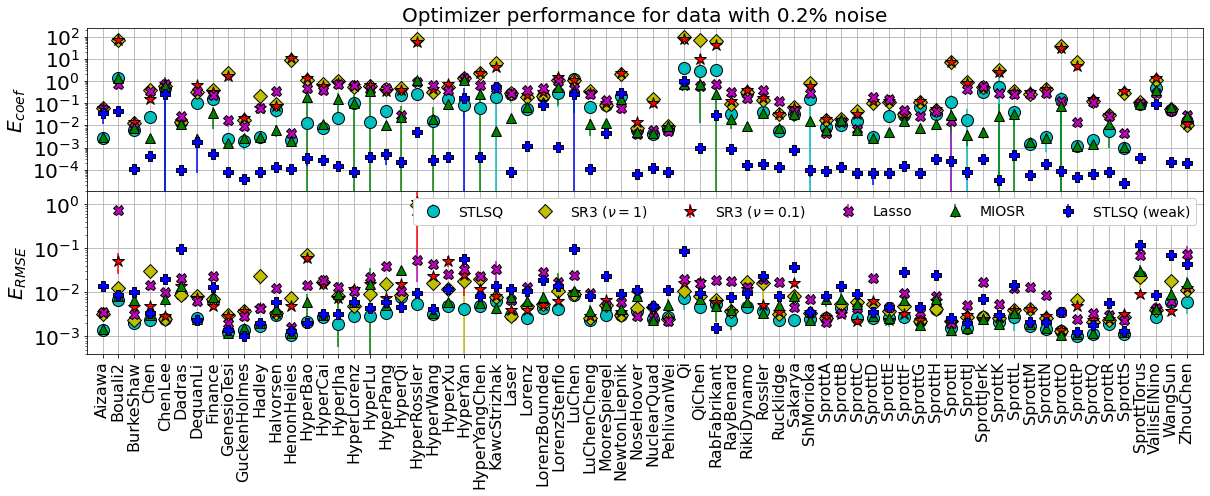

In [5]:
plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(2, 1, hspace=0, wspace=0)
plt.subplot(gs[0])
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_STLSQ_AIC_01,
    std_coef_error_STLSQ_AIC_01,
    fmt="co",
    label="STLSQ",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_SR3_AIC_01,
    std_coef_error_SR3_AIC_01,
    fmt="yD",
    label="SR3",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_SR3_nu01_AIC_01,
    std_coef_error_SR3_nu01_AIC_01,
    fmt="r*",
    label=r"SR3 $\nu = 0.1$",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_Lasso_AIC_01,
    std_coef_error_Lasso_AIC_01,
    fmt="mX",
    label="Lasso",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_MIOSR_AIC_01,
    std_coef_error_MIOSR_AIC_01,
    fmt="g^",
    label="MIOSR",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_STLSQ_AICwf_01,
    std_coef_error_STLSQ_AICwf_01,
    fmt="bP",
    label="STLSQ (weak)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.grid(True)
plt.yscale("log")
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-1, num_attractors)
ax.set_xticklabels([])
plt.yticks(fontsize=20)
plt.ylabel(r"$E_{coef}$", fontsize=20)
plt.title('Optimizer performance for data with 0.2% noise', fontsize=20)

plt.subplot(gs[1])
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_STLSQ_AIC_01,
    std_rmse_error_STLSQ_AIC_01,
    fmt="co",
    label="STLSQ",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_SR3_AIC_01,
    std_rmse_error_SR3_AIC_01,
    fmt="yD",
    label=r"SR3 ($\nu = 1$)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_SR3_nu01_AIC_01,
    std_rmse_error_SR3_nu01_AIC_01,
    fmt="r*",
    label=r"SR3 ($\nu = 0.1$)",
    markersize=ms + 2,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_Lasso_AIC_01,
    std_rmse_error_Lasso_AIC_01,
    fmt="mX",
    label="Lasso",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_MIOSR_AIC_01,
    std_rmse_error_MIOSR_AIC_01,
    fmt="g^",
    label="MIOSR",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_STLSQ_AICwf_01,
    std_rmse_error_STLSQ_AICwf_01,
    fmt="bP",
    label="STLSQ (weak)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.grid(True)
plt.yscale("log")
plt.legend(
    framealpha=1.0,
    ncol=6,
    fontsize=14,
)
plt.ylabel(r"$E_{RMSE}$", fontsize=20)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-1, num_attractors)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(fontsize=20)
plt.ylim(4e-4, 2)
plt.savefig("Pictures/optimizer_comparison_02percentnoise.pdf", bbox_inches = "tight")

### Plot all the errors for all the optimizers and all the systems, on a single figure!
Third plot will be all the results when the data has 2% Gaussian noise added to every point.

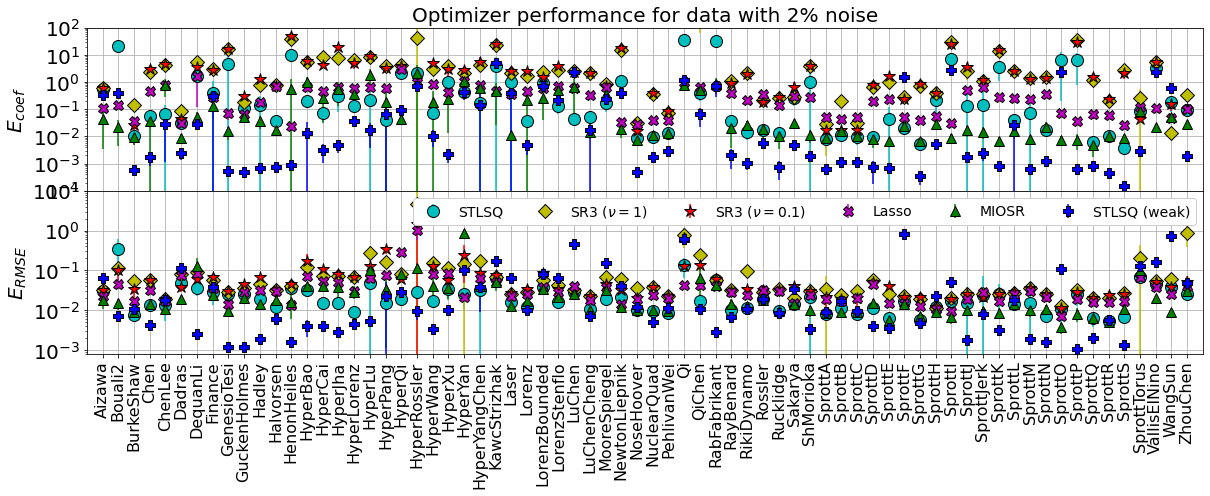

In [6]:
plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(2, 1, hspace=0, wspace=0)
plt.subplot(gs[0])
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_STLSQ_AIC_1,
    std_coef_error_STLSQ_AIC_1,
    fmt="co",
    label="STLSQ",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_SR3_AIC_1,
    std_coef_error_SR3_AIC_1,
    fmt="yD",
    label="SR3",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_SR3_nu01_AIC_1,
    std_coef_error_SR3_nu01_AIC_1,
    fmt="r*",
    label=r"SR3 $\nu = 0.1$",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_Lasso_AIC_1,
    std_coef_error_Lasso_AIC_1,
    fmt="mX",
    label="Lasso",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_MIOSR_AIC_1,
    std_coef_error_MIOSR_AIC_1,
    fmt="g^",
    label="MIOSR",
    markersize=ms,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_coef_error_STLSQ_AICwf_1,
    std_coef_error_STLSQ_AICwf_1,
    fmt="bP",
    label="STLSQ (weak)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.grid(True)
plt.yscale("log")
plt.ylim(1e-4, 1e2)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-1, num_attractors)
ax.set_xticklabels([])
plt.yticks(fontsize=20)
plt.ylabel(r"$E_{coef}$", fontsize=20)
plt.title('Optimizer performance for data with 2% noise', fontsize=20)

plt.subplot(gs[1])
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_STLSQ_AIC_1,
    std_rmse_error_STLSQ_AIC_1,
    fmt="co",
    label="STLSQ",
    markersize=ms + 2,
    markeredgecolor='k'
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_SR3_AIC_1,
    std_rmse_error_SR3_AIC_1,
    fmt="yD",
    label=r"SR3 ($\nu = 1$)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_SR3_nu01_AIC_1,
    std_rmse_error_SR3_nu01_AIC_1,
    fmt="r*",
    label=r"SR3 ($\nu = 0.1$)",
    markersize=ms + 2,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_Lasso_AIC_1,
    std_rmse_error_Lasso_AIC_1,
    fmt="mX",
    label="Lasso",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_MIOSR_AIC_1,
    std_rmse_error_MIOSR_AIC_1,
    fmt="g^",
    label="MIOSR",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.errorbar(
    np.arange(num_attractors),
    avg_rmse_error_STLSQ_AICwf_1,
    std_rmse_error_STLSQ_AICwf_1,
    fmt="bP",
    label="STLSQ (weak)",
    markersize=ms,
    markeredgecolor='k',
#     alpha=0.7
)
plt.grid(True)
plt.yscale("log")
plt.legend(
    #["10% normalized error", "$E_{coef}$", "$E_{RMSE}$", "Optimal threshold"],
    framealpha=1.0,
    ncol=6,
    fontsize=14,
    loc='upper right'
)
plt.ylabel(r"$E_{RMSE}$", fontsize=20)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-1, num_attractors)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(fontsize=20)
plt.ylim(0.8e-3, 1e1)
plt.savefig("Pictures/optimizer_comparison_2percentnoise.pdf", bbox_inches = "tight")

### Summarize the mean and median errors, now computed across all the dynamical systems
This gives an overall error performance for each optimizer, for each noise level, which can be plotted against the computational time used by the optimization algorithm.

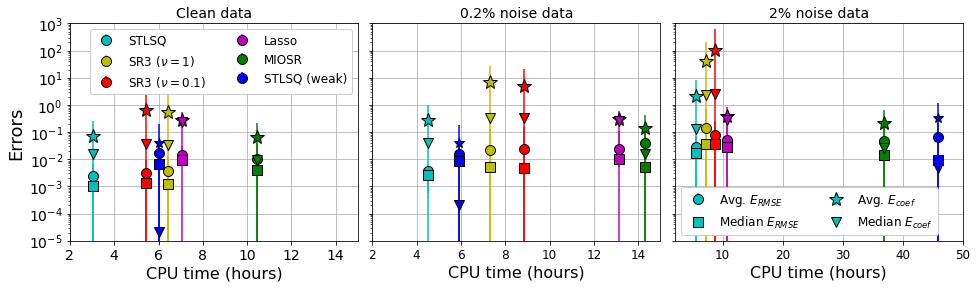

In [7]:
plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 3, hspace=0, wspace=0.05)
plt.subplot(gs[0])
plt.grid(True)
plt.yscale('log')
plt.ylabel("Errors", fontsize=18)
plt.title('Clean data', fontsize=14)
plt.errorbar(10936 / 3600, np.mean(avg_rmse_error_STLSQ_AIC), np.std(avg_rmse_error_STLSQ_AIC), fmt="co", label=r"STLSQ", markersize=ms, markeredgecolor='k')
plt.errorbar(23120 / 3600, np.mean(avg_rmse_error_SR3_AIC), np.std(avg_rmse_error_SR3_AIC), fmt="yo", label=r"SR3 ($\nu = 1$)", markersize=ms, markeredgecolor='k')
plt.errorbar(19604 / 3600, np.mean(avg_rmse_error_SR3_nu01_AIC), np.std(avg_rmse_error_SR3_nu01_AIC), label=r"SR3 ($\nu = 0.1$)", fmt="ro", markersize=ms, markeredgecolor='k')
plt.errorbar(25464 / 3600, np.mean(avg_rmse_error_Lasso_AIC), np.std(avg_rmse_error_Lasso_AIC), fmt="mo", label=r"Lasso", markersize=ms, markeredgecolor='k')
plt.errorbar(37662 / 3600, np.mean(avg_rmse_error_MIOSR_AIC), np.std(avg_rmse_error_MIOSR_AIC), fmt="go", label=r"MIOSR", markersize=ms, markeredgecolor='k')
plt.errorbar(21606 / 3600, np.mean(avg_rmse_error_STLSQ_AICwf), np.std(avg_rmse_error_STLSQ_AICwf), fmt="bo", label=r"STLSQ (weak)", markersize=ms, markeredgecolor='k')
plt.legend(framealpha=1.0, fontsize=12, ncol=2, loc='best')

plt.subplot(gs[1])
plt.grid(True)
plt.yscale('log')
plt.title('0.2% noise data', fontsize=14)
plt.errorbar(16311 / 3600, np.mean(avg_rmse_error_STLSQ_AIC_01), np.std(avg_rmse_error_STLSQ_AIC_01), fmt="co", label=r"Avg. $E_{RMSE}$ (0.2% noise)", markersize=ms, markeredgecolor='k')
plt.errorbar(26270 / 3600, np.mean(avg_rmse_error_SR3_AIC_01), np.std(avg_rmse_error_SR3_AIC_01), fmt="yo", markersize=ms, markeredgecolor='k')
plt.errorbar(31907 / 3600, np.mean(avg_rmse_error_SR3_nu01_AIC_01), np.std(avg_rmse_error_SR3_nu01_AIC_01), fmt="ro", markersize=ms, markeredgecolor='k')
plt.errorbar(47287 / 3600, np.mean(avg_rmse_error_Lasso_AIC_01), np.std(avg_rmse_error_Lasso_AIC_01), fmt="mo", markersize=ms, markeredgecolor='k')
plt.errorbar(51481 / 3600, np.mean(avg_rmse_error_MIOSR_AIC_01), np.std(avg_rmse_error_MIOSR_AIC_01), fmt="go", markersize=ms, markeredgecolor='k')
plt.errorbar(21208 / 3600, np.mean(avg_rmse_error_STLSQ_AICwf_01), np.std(avg_rmse_error_STLSQ_AICwf_01), fmt="bo", markersize=ms, markeredgecolor='k')

plt.subplot(gs[2])
plt.grid(True)
plt.yscale('log')
plt.title('2% noise data', fontsize=14)
plt.errorbar(19767 / 3600, np.mean(avg_rmse_error_STLSQ_AIC_1), np.std(avg_rmse_error_STLSQ_AIC_1), fmt="co", label=r"Avg. $E_{RMSE}$", markersize=ms, markeredgecolor='k')
plt.errorbar(26017 / 3600, np.mean(avg_rmse_error_SR3_AIC_1), np.std(avg_rmse_error_SR3_AIC_1), fmt="yo", markersize=ms, markeredgecolor='k')
plt.errorbar(31447 / 3600, np.mean(avg_rmse_error_SR3_nu01_AIC_1), np.std(avg_rmse_error_SR3_nu01_AIC_1), fmt="ro", markersize=ms, markeredgecolor='k')
plt.errorbar(38549 / 3600, np.mean(avg_rmse_error_Lasso_AIC_1), np.std(avg_rmse_error_Lasso_AIC_1), fmt="mo", markersize=ms, markeredgecolor='k')
plt.errorbar(132848 / 3600, np.mean(avg_rmse_error_MIOSR_AIC_1), np.std(avg_rmse_error_MIOSR_AIC_1), fmt="go", markersize=ms, markeredgecolor='k')
plt.errorbar(165048 / 3600, np.mean(avg_rmse_error_STLSQ_AICwf_1), np.std(avg_rmse_error_STLSQ_AICwf_1), fmt="bo", markersize=ms, markeredgecolor='k')

plt.subplot(gs[0])
plt.ylim(1e-5, 1e3)
plt.errorbar(10936 / 3600, np.median(avg_rmse_error_STLSQ_AIC), fmt="cs", label=r"Median $E_{RMSE}$ (clean)", markersize=ms, markeredgecolor='k')
plt.errorbar(23120 / 3600, np.median(avg_rmse_error_SR3_AIC), fmt="ys", markersize=ms, markeredgecolor='k')
plt.errorbar(19604 / 3600, np.median(avg_rmse_error_SR3_nu01_AIC), fmt="rs", markersize=ms, markeredgecolor='k')
plt.errorbar(25464 / 3600, np.median(avg_rmse_error_Lasso_AIC), fmt="ms", markersize=ms, markeredgecolor='k')
plt.errorbar(37662 / 3600, np.median(avg_rmse_error_MIOSR_AIC), fmt="gs", markersize=ms, markeredgecolor='k')
plt.errorbar(21606 / 3600, np.median(avg_rmse_error_STLSQ_AICwf), fmt="bs", markersize=ms, markeredgecolor='k')

plt.subplot(gs[1])
plt.ylim(1e-5, 1e3)
ax = plt.gca()
ax.set_yticklabels([])
plt.errorbar(16311 / 3600, np.median(avg_rmse_error_STLSQ_AIC_01), fmt="cs", label=r"Median $E_{RMSE}$ (0.2% noise)", markersize=ms, markeredgecolor='k')
plt.errorbar(26270 / 3600, np.median(avg_rmse_error_SR3_AIC_01), fmt="ys", markersize=ms, markeredgecolor='k')
plt.errorbar(31907 / 3600, np.median(avg_rmse_error_SR3_nu01_AIC_01), fmt="rs", markersize=ms, markeredgecolor='k')
plt.errorbar(47287 / 3600, np.median(avg_rmse_error_Lasso_AIC_01), fmt="ms", markersize=ms, markeredgecolor='k')
plt.errorbar(51481 / 3600, np.median(avg_rmse_error_MIOSR_AIC_01), fmt="gs", markersize=ms, markeredgecolor='k')
plt.errorbar(21208 / 3600, np.median(avg_rmse_error_STLSQ_AICwf_01), fmt="bs", markersize=ms, markeredgecolor='k')

plt.subplot(gs[2])
plt.ylim(1e-5, 1e3)
ax = plt.gca()
ax.set_yticklabels([])
plt.errorbar(19767 / 3600, np.median(avg_rmse_error_STLSQ_AIC_1), fmt="cs", label=r"Median $E_{RMSE}$", markersize=ms, markeredgecolor='k')
plt.errorbar(26017 / 3600, np.median(avg_rmse_error_SR3_AIC_1), fmt="ys", markersize=ms, markeredgecolor='k')
plt.errorbar(31447 / 3600, np.median(avg_rmse_error_SR3_nu01_AIC_1), fmt="rs", markersize=ms, markeredgecolor='k')
plt.errorbar(38549 / 3600, np.median(avg_rmse_error_Lasso_AIC_1), fmt="ms", markersize=ms, markeredgecolor='k')
plt.errorbar(132848 / 3600, np.median(avg_rmse_error_MIOSR_AIC_1), fmt="gs", markersize=ms, markeredgecolor='k')
plt.errorbar(165048 / 3600, np.median(avg_rmse_error_STLSQ_AICwf_1), fmt="bs", markersize=ms, markeredgecolor='k')

plt.subplot(gs[0])
plt.xlabel("CPU time (hours)", fontsize=16)
plt.errorbar(10936 / 3600, np.mean(avg_coef_error_STLSQ_AIC), np.std(avg_coef_error_STLSQ_AIC), fmt="c*", label=r"Avg. $E_{coef}$", markersize=ms+5, markeredgecolor='k')
plt.errorbar(23120 / 3600, np.mean(avg_coef_error_SR3_AIC), np.std(avg_coef_error_SR3_AIC), fmt="y*", markersize=ms+5, markeredgecolor='k') #, label=r"SR3 ($\nu = 1$)")
plt.errorbar(19604 / 3600, np.mean(avg_coef_error_SR3_nu01_AIC), np.std(avg_coef_error_SR3_nu01_AIC), fmt="r*", markersize=ms+5, markeredgecolor='k') #, label=r"SR3 ($\nu = 0.1$)")
plt.errorbar(25464 / 3600, np.mean(avg_coef_error_Lasso_AIC), np.std(avg_coef_error_Lasso_AIC), fmt="m*", markersize=ms+5, markeredgecolor='k') #, label="Lasso")
plt.errorbar(37662 / 3600, np.mean(avg_coef_error_MIOSR_AIC), np.std(avg_coef_error_MIOSR_AIC), fmt="g*", markersize=ms+5, markeredgecolor='k') #, label="MIOSR")
plt.errorbar(21606 / 3600, np.mean(avg_coef_error_STLSQ_AICwf), np.std(avg_coef_error_STLSQ_AICwf), fmt="b*", markersize=ms, markeredgecolor='k')

plt.subplot(gs[1])
plt.xlabel("CPU time (hours)", fontsize=16)
plt.errorbar(16311 / 3600, np.mean(avg_coef_error_STLSQ_AIC_01), np.std(avg_coef_error_STLSQ_AIC_01), fmt="c*", label=r"Avg. $E_{coef}$ (0.2% noise)", markersize=ms+5, markeredgecolor='k')
plt.errorbar(26270 / 3600, np.mean(avg_coef_error_SR3_AIC_01), np.std(avg_coef_error_SR3_AIC_01), fmt="y*", markersize=ms+5, markeredgecolor='k') #, label=r"SR3 ($\nu = 1$)")
plt.errorbar(31907 / 3600, np.mean(avg_coef_error_SR3_nu01_AIC_01), np.std(avg_coef_error_SR3_nu01_AIC_01), fmt="r*", markersize=ms+5, markeredgecolor='k') #, label=r"SR3 ($\nu = 0.1$)")
plt.errorbar(47287 / 3600, np.mean(avg_coef_error_Lasso_AIC_01), np.std(avg_coef_error_Lasso_AIC_01), fmt="m*", markersize=ms+5, markeredgecolor='k') #, label="Lasso")
plt.errorbar(51481 / 3600, np.mean(avg_coef_error_MIOSR_AIC_01), np.std(avg_coef_error_MIOSR_AIC_01), fmt="g*", markersize=ms+5, markeredgecolor='k') #, label="MIOSR")
plt.errorbar(21208 / 3600, np.mean(avg_coef_error_STLSQ_AICwf_01), np.std(avg_coef_error_STLSQ_AICwf_01), fmt="b*", markersize=ms, markeredgecolor='k')

plt.subplot(gs[2])
plt.errorbar(19767 / 3600, np.mean(avg_coef_error_STLSQ_AIC_1), np.std(avg_coef_error_STLSQ_AIC_1), fmt="c*", label=r"Avg. $E_{coef}$", markersize=ms+5, markeredgecolor='k')
plt.errorbar(26017 / 3600, np.mean(avg_coef_error_SR3_AIC_1), np.std(avg_coef_error_SR3_AIC_1), fmt="y*", markersize=ms+5, markeredgecolor='k') #, label=r"SR3 ($\nu = 1$)")
plt.errorbar(31447 / 3600, np.mean(avg_coef_error_SR3_nu01_AIC_1), np.std(avg_coef_error_SR3_nu01_AIC_1), fmt="r*", markersize=ms+5, markeredgecolor='k') #, label=r"SR3 ($\nu = 0.1$)")
plt.errorbar(38549 / 3600, np.mean(avg_coef_error_Lasso_AIC_1), np.std(avg_coef_error_Lasso_AIC_1), fmt="m*", markersize=ms+5, markeredgecolor='k') #, label="Lasso")
plt.errorbar(132848 / 3600, np.mean(avg_coef_error_MIOSR_AIC_1), np.std(avg_coef_error_MIOSR_AIC_1), fmt="g*", markersize=ms+5, markeredgecolor='k') #, label="MIOSR")
plt.errorbar(165048 / 3600, np.mean(avg_coef_error_STLSQ_AICwf_1), np.std(avg_coef_error_STLSQ_AICwf_1), fmt="b*", markersize=ms, markeredgecolor='k')

plt.subplot(gs[0])
plt.xlim(2, 15)
plt.errorbar(10936 / 3600, np.median(avg_coef_error_STLSQ_AIC), fmt="cv", label=r"Median $E_{coef}$", markersize=ms, markeredgecolor='k')
plt.errorbar(23120 / 3600, np.median(avg_coef_error_SR3_AIC), fmt="yv", markersize=ms, markeredgecolor='k')
plt.errorbar(19604 / 3600, np.median(avg_coef_error_SR3_nu01_AIC), fmt="rv", markersize=ms, markeredgecolor='k')
plt.errorbar(25464 / 3600, np.median(avg_coef_error_Lasso_AIC), fmt="mv", markersize=ms, markeredgecolor='k')
plt.errorbar(37662 / 3600, np.median(avg_coef_error_MIOSR_AIC), fmt="gv", markersize=ms, markeredgecolor='k')
plt.errorbar(21606 / 3600, np.median(avg_coef_error_STLSQ_AICwf), fmt="bv", markersize=ms, markeredgecolor='k')

plt.subplot(gs[1])
plt.xlim(2, 15)
plt.xticks(fontsize=12)
plt.errorbar(16311 / 3600, np.median(avg_coef_error_STLSQ_AIC_01), fmt="cv", label=r"Median $E_{coef}$", markersize=ms, markeredgecolor='k')
plt.errorbar(26270 / 3600, np.median(avg_coef_error_SR3_AIC_01), fmt="yv", markersize=ms, markeredgecolor='k')
plt.errorbar(31907 / 3600, np.median(avg_coef_error_SR3_nu01_AIC_01), fmt="rv", markersize=ms, markeredgecolor='k')
plt.errorbar(47287 / 3600, np.median(avg_coef_error_Lasso_AIC_01), fmt="mv", markersize=ms, markeredgecolor='k')
plt.errorbar(51481 / 3600, np.median(avg_coef_error_MIOSR_AIC_01), fmt="gv", markersize=ms, markeredgecolor='k')
plt.errorbar(21208 / 3600, np.median(avg_coef_error_STLSQ_AICwf_01), fmt="bv", markersize=ms, markeredgecolor='k')

plt.subplot(gs[2])
plt.xticks(fontsize=12)
plt.errorbar(19767 / 3600, np.median(avg_coef_error_STLSQ_AIC_1), fmt="cv", label=r"Median $E_{coef}$", markersize=ms, markeredgecolor='k')
plt.errorbar(26017 / 3600, np.median(avg_coef_error_SR3_AIC_1), fmt="yv", markersize=ms, markeredgecolor='k')
plt.errorbar(31447 / 3600, np.median(avg_coef_error_SR3_nu01_AIC_1), fmt="rv", markersize=ms, markeredgecolor='k')
plt.errorbar(38549 / 3600, np.median(avg_coef_error_Lasso_AIC_1), fmt="mv", markersize=ms, markeredgecolor='k')
plt.errorbar(132848 / 3600, np.median(avg_coef_error_MIOSR_AIC_1), fmt="gv", markersize=ms, markeredgecolor='k')
plt.errorbar(165048 / 3600, np.median(avg_coef_error_STLSQ_AICwf_1), fmt="bv", markersize=ms, markeredgecolor='k')

# plt.xscale('log')
plt.xlim(2, 50)
plt.xlabel("CPU time (hours)", fontsize=16)
plt.legend(framealpha=1.0, fontsize=12, ncol=2)
# plt.title('Average optimizer performance vs run time', fontsize=14)
#plt.ylim(5e-4, 1e2)
plt.subplot(gs[0])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig('Pictures/optimizer_error_summary.pdf')
plt.show()

# Does symbolic regression depend on dynamical properties?
Dynamical properties of interest include:
1. Level of chaos, as measured by the largest Lyapunov exponent,
2. Scale separation, as measured by the ratio of the "dominant" timescale to the "minimum significant" time scale (see William Gilpin's dysts paper),
3. Syntactical complexity, as measured by the description length metric,
4. Degree of nonlinearity, measured as the highest polynomially nonlinearity appearing in the governing equations. 

### Take errors from one of the optimizer results, and plot how the performance depends on the dynamical properties

R^2 value for RMSE error =  0.004725379007601838
Log-Linear R^2 value for RMSE error =  0.006280905416942987
Log-Log R^2 value for RMSE error =  0.016982873367031887
R^2 value for coef error =  0.0008149909382449447
Chaos
R^2 value for RMSE error =  0.021074737261039832
Log-Linear R^2 value for RMSE error =  0.11987522498739314
Log-Log R^2 value for RMSE error =  0.32361186518847096
R^2 value for coef error =  0.02028620794199837
Syntax
R^2 value for RMSE error =  0.029820717676927077
Log-Linear R^2 value for RMSE error =  0.11893772520074478
Log-Log R^2 value for RMSE error =  0.29137739801005874
R^2 value for coef error =  0.0156148412520991
Nonlinearity
R^2 value for RMSE error =  0.03837464206218513
Log-Linear R^2 value for RMSE error =  0.12042007407012754
Log-Log R^2 value for RMSE error =  0.2977989737371275
R^2 value for coef error =  0.020202571831866033


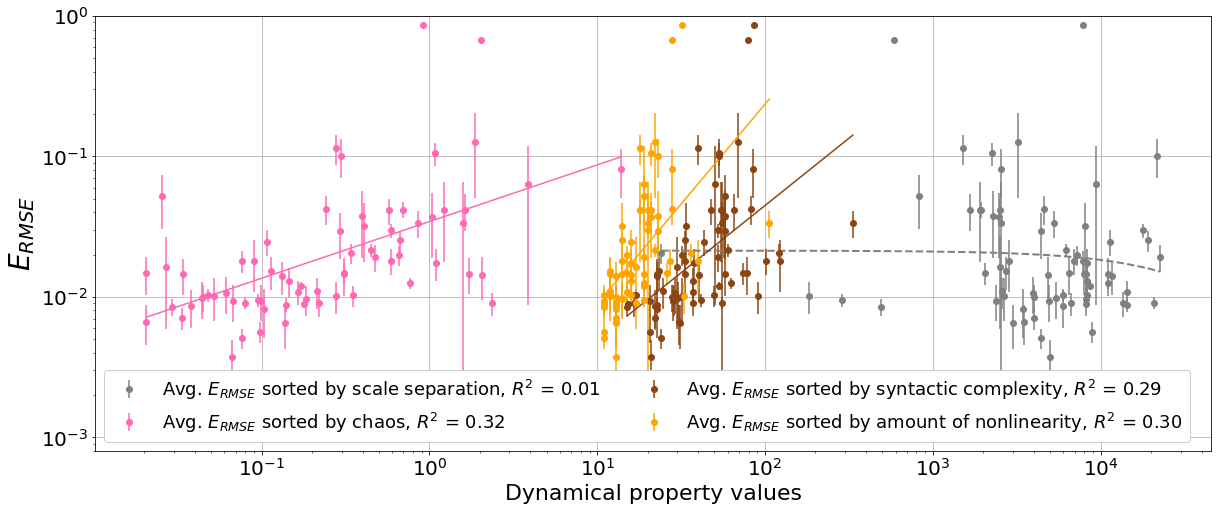

In [8]:
from scipy.stats import linregress

# get the errors from one of the optimizer results
cerrs = avg_coef_error_MIOSR_AIC
avg_rmse_error = avg_rmse_error_MIOSR_AIC_1
std_rmse_error = std_rmse_error_MIOSR_AIC_1

# reorder things by the amount of scale separation and then plot performance + fits
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
    scale_list_sorted, np.log(avg_rmse_error[scale_sort])
)
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
    np.log(scale_list_sorted), np.log(avg_rmse_error[scale_sort])
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print("R^2 value for RMSE error = ", r_value**2)
print("Log-Linear R^2 value for RMSE error = ", r_value1**2)
print("Log-Log R^2 value for RMSE error = ", r_value2**2)
print("R^2 value for coef error = ", r_value_coef**2)
plt.figure(figsize=(20, 8))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    color='grey',
    fmt="o",
    label="Avg. $E_{RMSE}$ sorted by scale separation, $R^2$ = " + "{0:.2f}".format(r_value1**2)
)
plt.plot(scale_list_sorted, np.exp(slope1 * scale_list_sorted + intercept1), 
         color="grey", linestyle='--', linewidth=2)

# now repeat for the level of chaos
scale_sort = np.argsort(lyap_list)
scale_list_sorted = np.sort(lyap_list)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
    scale_list_sorted, np.log(avg_rmse_error[scale_sort])
)
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
    np.log(scale_list_sorted), np.log(avg_rmse_error[scale_sort])
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print('Chaos')
print("R^2 value for RMSE error = ", r_value**2)
print("Log-Linear R^2 value for RMSE error = ", r_value1**2)
print("Log-Log R^2 value for RMSE error = ", r_value2**2)
print("R^2 value for coef error = ", r_value_coef**2)
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    color='hotpink',
    fmt="o",
    label="Avg. $E_{RMSE}$ sorted by chaos, $R^2$ = " + "{0:.2f}".format(r_value2**2)
)
plt.plot(scale_list_sorted, np.exp(intercept2) * scale_list_sorted ** slope2, "hotpink", )

# now repeat for the description length
scale_sort = np.argsort(medl_list)
scale_list_sorted = np.array(np.sort(medl_list), dtype=float)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
    scale_list_sorted, np.log(avg_rmse_error[scale_sort])
)
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
    np.log(scale_list_sorted), np.log(avg_rmse_error[scale_sort])
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print('Syntax')
print("R^2 value for RMSE error = ", r_value**2)
print("Log-Linear R^2 value for RMSE error = ", r_value1**2)
print("Log-Log R^2 value for RMSE error = ", r_value2**2)
print("R^2 value for coef error = ", r_value_coef**2)
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    color='saddlebrown',
    fmt="o",
    label="Avg. $E_{RMSE}$ sorted by syntactic complexity, $R^2$ = " + "{0:.2f}".format(r_value2**2)
)
plt.plot(scale_list_sorted, np.exp(intercept2) * scale_list_sorted ** slope2, "saddlebrown", )

# now repeat for the amount of nonlinearity
scale_sort = np.argsort(nonlinear_sum)
scale_list_sorted = np.array(np.sort(nonlinear_sum), dtype=float)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
    scale_list_sorted, np.log(avg_rmse_error[scale_sort])
)
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
    np.log(scale_list_sorted), np.log(avg_rmse_error[scale_sort])
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print('Nonlinearity')
print("R^2 value for RMSE error = ", r_value**2)
print("Log-Linear R^2 value for RMSE error = ", r_value1**2)
print("Log-Log R^2 value for RMSE error = ", r_value2**2)
print("R^2 value for coef error = ", r_value_coef**2)
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    color='orange',
    fmt="o",
    label="Avg. $E_{RMSE}$ sorted by amount of nonlinearity, $R^2$ = " + "{0:.2f}".format(r_value2**2)
)
plt.plot(scale_list_sorted, np.exp(intercept2) * scale_list_sorted ** slope2, "orange", )

# polish the figure
plt.xscale("log")
plt.grid(True)
plt.yscale('log')
plt.legend(
    loc="lower left",
    framealpha=1.0,
    ncol=2,
    fontsize=18,
)
ax = plt.gca()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Dynamical property values', fontsize=22)
plt.ylabel(r'$E_{RMSE}$', fontsize=28)
plt.ylim(0.8e-3, 1)
# plt.savefig('MIOSR_noise1_dynamical_property_fits.pdf')
plt.show()

### Summarize the $R^2$ values for all the fits of all the optimizers, at each noise level
Rather than producing the rather complicated plot above over and over, here we record the $R^2$ coefficients of determination for each fit of (dynamical property, RMSE error), and plot the results.

In [9]:
error_list = [(avg_rmse_error_STLSQ_AIC, std_rmse_error_STLSQ_AIC),
              (avg_rmse_error_STLSQ_AIC_01, std_rmse_error_STLSQ_AIC_01),
              (avg_rmse_error_STLSQ_AIC_1, std_rmse_error_STLSQ_AIC_1),
              (avg_rmse_error_SR3_AIC, std_rmse_error_SR3_AIC),
              (avg_rmse_error_SR3_AIC_01, std_rmse_error_SR3_AIC_01),
              (avg_rmse_error_SR3_AIC_1, std_rmse_error_SR3_AIC_1),
              (avg_rmse_error_SR3_nu01_AIC, std_rmse_error_SR3_nu01_AIC),
              (avg_rmse_error_SR3_nu01_AIC_01, std_rmse_error_SR3_nu01_AIC_01),
              (avg_rmse_error_SR3_nu01_AIC_1, std_rmse_error_SR3_nu01_AIC_1),
              (avg_rmse_error_Lasso_AIC, std_rmse_error_Lasso_AIC),
              (avg_rmse_error_Lasso_AIC_01, std_rmse_error_Lasso_AIC_01),
              (avg_rmse_error_Lasso_AIC_1, std_rmse_error_Lasso_AIC_1),
              (avg_rmse_error_MIOSR_AIC, std_rmse_error_MIOSR_AIC),
              (avg_rmse_error_MIOSR_AIC_01, std_rmse_error_MIOSR_AIC_01),
              (avg_rmse_error_MIOSR_AIC_1, std_rmse_error_MIOSR_AIC_1),
              (avg_rmse_error_STLSQ_AICwf, std_rmse_error_STLSQ_AICwf),
              (avg_rmse_error_STLSQ_AICwf_01, std_rmse_error_STLSQ_AICwf_01),
              (avg_rmse_error_STLSQ_AICwf_1, std_rmse_error_STLSQ_AICwf_1),]

scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)
chaos_sort = np.argsort(lyap_list)
chaos_list_sorted = np.sort(lyap_list)
syntax_sort = np.argsort(medl_list)
syntax_list_sorted = np.sort(medl_list)
nonlinear_sort = np.argsort(nonlinear_sum)
nonlinear_list_sorted = np.sort(nonlinear_sum)
r_values_scale = []
r_values_chaos = []
r_values_syntax = []
r_values_nonlinear = []
for i in range(len(error_list)):
    avg_rmse_error, std_rmse_error = error_list[i]
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
        scale_list_sorted, np.log(avg_rmse_error[scale_sort])
    )
    r_values_scale.append(r_value1 ** 2)

    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
        np.log(chaos_list_sorted), np.log(avg_rmse_error[chaos_sort])
    )
    r_values_chaos.append(r_value2 ** 2)

    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
        np.log(syntax_list_sorted), np.log(avg_rmse_error[syntax_sort])
    )
    r_values_syntax.append(r_value2 ** 2)
    
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
        np.log(nonlinear_list_sorted), np.log(avg_rmse_error[nonlinear_sort])
    )
    r_values_nonlinear.append(r_value2 ** 2)


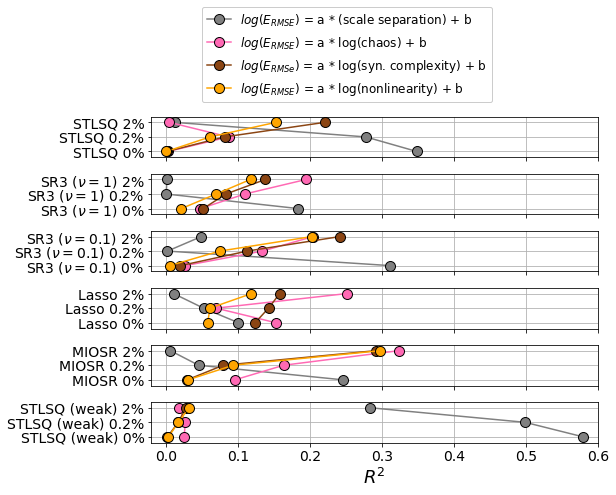

In [10]:
ms = 10
plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(6, 1, hspace=0.4, wspace=0)
opt_list = ['STLSQ', r'SR3 ($\nu = 1$)', r'SR3 ($\nu = 0.1$)', r'Lasso', r'MIOSR', 'STLSQ (weak)']
for i in range(6):
    plt.subplot(gs[i])
    plt.plot(r_values_scale[i * 3: (i + 1) * 3], np.arange(3), color='grey', marker='o', markersize=ms, markeredgecolor='k', label=r'$log(E_{RMSE})$ = a * (scale separation) + b')
    plt.plot(r_values_chaos[i * 3: (i + 1) * 3], np.arange(3), color='hotpink', marker='o', markersize=ms, markeredgecolor='k',label=r'$log(E_{RMSE})$ = a * log(chaos) + b')
    plt.plot(r_values_syntax[i * 3: (i + 1) * 3], np.arange(3), color='saddlebrown', marker='o', markersize=ms, markeredgecolor='k',label=r'$log(E_{RMSe})$ = a * log(syn. complexity) + b')
    plt.plot(r_values_nonlinear[i * 3: (i + 1) * 3], np.arange(3), color='orange', marker='o', markersize=ms, markeredgecolor='k',label=r'$log(E_{RMSE})$ = a * log(nonlinearity) + b')
    plt.grid(True)
    plt.yticks(np.arange(3), fontsize=14)
    ax = plt.gca()
    plt.xlim(-0.02, 0.6)
    plt.ylim(-0.4, 2.4)
    ax.set_yticklabels([opt_list[i] + ' 0%', opt_list[i] + ' 0.2%', opt_list[i] + ' 2%'])
    if i == 0:
        plt.legend(fontsize=12, framealpha=1, ncol=1, bbox_to_anchor=(0.1, 1.2))
    if i != 5:
        ax.set_xticklabels([])

plt.xlabel(r'$R^2$', fontsize=18)
plt.xticks(fontsize=14)
plt.savefig('Pictures/best_r2_values_rmse_error.pdf', bbox_inches = 'tight')
plt.show()

### Now we repeat with the coefficient errors instead of the RMSE errors

In [11]:
error_list = [(avg_coef_error_STLSQ_AIC, std_coef_error_STLSQ_AIC),
              (avg_coef_error_STLSQ_AIC_01, std_coef_error_STLSQ_AIC_01),
              (avg_coef_error_STLSQ_AIC_1, std_coef_error_STLSQ_AIC_1),
              (avg_coef_error_SR3_AIC, std_coef_error_SR3_AIC),
              (avg_coef_error_SR3_AIC_01, std_coef_error_SR3_AIC_01),
              (avg_coef_error_SR3_AIC_1, std_coef_error_SR3_AIC_1),
              (avg_coef_error_SR3_nu01_AIC, std_coef_error_SR3_nu01_AIC),
              (avg_coef_error_SR3_nu01_AIC_01, std_coef_error_SR3_nu01_AIC_01),
              (avg_coef_error_SR3_nu01_AIC_1, std_coef_error_SR3_nu01_AIC_1),
              (avg_coef_error_Lasso_AIC, std_coef_error_Lasso_AIC),
              (avg_coef_error_Lasso_AIC_01, std_coef_error_Lasso_AIC_01),
              (avg_coef_error_Lasso_AIC_1, std_coef_error_Lasso_AIC_1),
              (avg_coef_error_MIOSR_AIC, std_coef_error_MIOSR_AIC),
              (avg_coef_error_MIOSR_AIC_01, std_coef_error_MIOSR_AIC_01),
              (avg_coef_error_MIOSR_AIC_1, std_coef_error_MIOSR_AIC_1),
              (avg_coef_error_STLSQ_AICwf, std_coef_error_STLSQ_AICwf),
              (avg_coef_error_STLSQ_AICwf_01, std_coef_error_STLSQ_AICwf_01),
              (avg_coef_error_STLSQ_AICwf_1, std_coef_error_STLSQ_AICwf_1),]

scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)
chaos_sort = np.argsort(lyap_list)
chaos_list_sorted = np.sort(lyap_list)
syntax_sort = np.argsort(medl_list)
syntax_list_sorted = np.sort(medl_list)
nonlinear_sort = np.argsort(nonlinear_sum)
nonlinear_list_sorted = np.sort(nonlinear_sum)
r_values_scale = []
r_values_chaos = []
r_values_syntax = []
r_values_nonlinear = []
for i in range(len(error_list)):
    avg_coef_error, std_coef_error = error_list[i]
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
        scale_list_sorted, np.log(avg_coef_error[scale_sort])
    )
    r_values_scale.append(r_value1 ** 2)

    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
        np.log(chaos_list_sorted), np.log(avg_coef_error[chaos_sort])
    )
    r_values_chaos.append(r_value2 ** 2)

    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
        np.log(syntax_list_sorted), np.log(avg_coef_error[syntax_sort])
    )
    r_values_syntax.append(r_value2 ** 2)
    
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
        np.log(nonlinear_list_sorted), np.log(avg_coef_error[nonlinear_sort])
    )
    r_values_nonlinear.append(r_value2 ** 2)


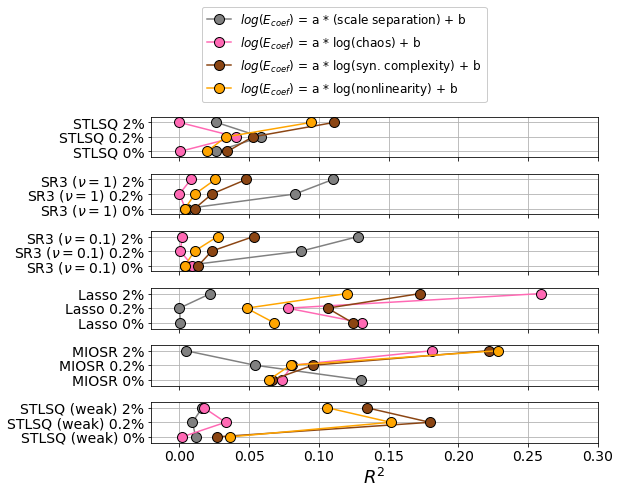

In [12]:
ms = 10
plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(6, 1, hspace=0.4, wspace=0)
opt_list = ['STLSQ', r'SR3 ($\nu = 1$)', r'SR3 ($\nu = 0.1$)', r'Lasso', r'MIOSR', 'STLSQ (weak)']
# plt.subplot(gs[0])
for i in range(6):
    plt.subplot(gs[i])
    plt.plot(r_values_scale[i * 3: (i + 1) * 3], np.arange(3), color='grey', marker='o', markersize=ms, markeredgecolor='k', label=r'$log(E_{coef})$ = a * (scale separation) + b')
    plt.plot(r_values_chaos[i * 3: (i + 1) * 3], np.arange(3), color='hotpink', marker='o', markersize=ms, markeredgecolor='k',label=r'$log(E_{coef})$ = a * log(chaos) + b')
    plt.plot(r_values_syntax[i * 3: (i + 1) * 3], np.arange(3), color='saddlebrown', marker='o', markersize=ms, markeredgecolor='k',label=r'$log(E_{coef})$ = a * log(syn. complexity) + b')
    plt.plot(r_values_nonlinear[i * 3: (i + 1) * 3], np.arange(3), color='orange', marker='o', markersize=ms, markeredgecolor='k',label=r'$log(E_{coef})$ = a * log(nonlinearity) + b')
    plt.grid(True)
    plt.yticks(np.arange(3), fontsize=14)
    ax = plt.gca()
    plt.xlim(-0.02, 0.3)
    plt.ylim(-0.4, 2.4)
    ax.set_yticklabels([opt_list[i] + ' 0%', opt_list[i] + ' 0.2%', opt_list[i] + ' 2%'])
    if i == 0:
        plt.legend(fontsize=12, framealpha=1, ncol=1, bbox_to_anchor=(0.1, 1.2))
    if i != 5:
        ax.set_xticklabels([])

plt.xlabel(r'$R^2$', fontsize=18)
plt.xticks(fontsize=14)
plt.savefig('Pictures/best_r2_values_coef_error.pdf')
plt.show()